In [39]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf
import darts.utils.timeseries_generation as tg
from darts.datasets import AirPassengersDataset, EnergyDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.missing_values import fill_missing_values
from darts.utils.likelihood_models import GaussianLikelihood

import warnings
import logging
warnings.filterwarnings("ignore")
logging.disable(logging.CRITICAL)

In [41]:
length = 400
trend = tg.linear_timeseries(length=length, end_value=4)
season1 = tg.sine_timeseries(length=length, value_frequency=0.05, value_amplitude=1.0)
noise = tg.gaussian_timeseries(length=length, std=0.6)
noise_modulator = (
    tg.sine_timeseries(length=length, value_frequency=0.02)
    + tg.constant_timeseries(length=length, value=1)
) / 2
noise = noise * noise_modulator

target_series = sum([noise, season1])
covariates = noise_modulator
target_train, target_val = target_series.split_after(0.65)

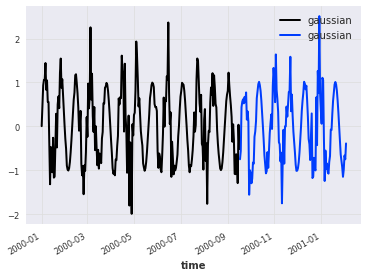

In [42]:
target_train.plot()
target_val.plot()

In [43]:
my_model = RNNModel(
    model="LSTM",
    hidden_dim=20,
    dropout=0,
    batch_size=16,
    n_epochs=50,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    training_length=50,
    input_chunk_length=20,
    likelihood=GaussianLikelihood(),
    force_reset=True,
    pl_trainer_kwargs={"accelerator": "gpu", "gpus":[0]}
)

my_model.fit(target_train, future_covariates=covariates, verbose=True)

Training: 0it [00:00, ?it/s]

Predicting: 14it [00:00, ?it/s]

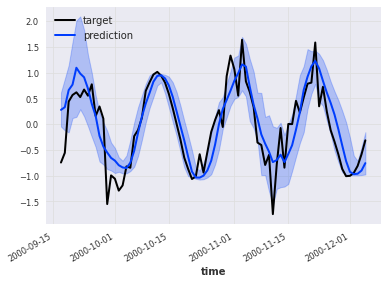

In [44]:
pred = my_model.predict(80, num_samples=50)
target_val.slice_intersect(pred).plot(label="target")
pred.plot(label="prediction")

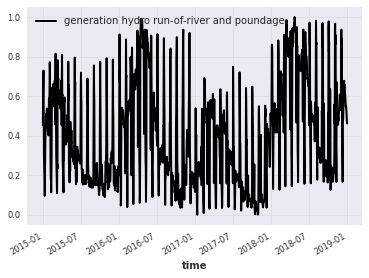

In [45]:
df3 = EnergyDataset().load().pd_dataframe()
df3_day_avg = (
    df3.groupby(df3.index.astype(str).str.split(" ").str[0]).mean().reset_index()
)
series_en = fill_missing_values(
    TimeSeries.from_dataframe(
        df3_day_avg, "time", ["generation hydro run-of-river and poundage"]
    ),
    "auto",
)

# convert to float32
series_en = series_en.astype(np.float32)

# scale
scaler_en = Scaler()
series_en_transformed = scaler_en.fit_transform(series_en)
train_en_transformed, val_en_transformed = series_en_transformed.split_after(
    pd.Timestamp("20170901")
)

# add the day as a covariate
day_series = datetime_attribute_timeseries(
    series_en_transformed, attribute="day", one_hot=True, dtype=np.float32
)
scaler_day = Scaler()
day_series = scaler_day.fit_transform(day_series)
train_day, val_day = day_series.split_after(pd.Timestamp("20170901"))

series_en_transformed.plot()

In [46]:
model_en = RNNModel(
    model="LSTM",
    hidden_dim=20,
    n_rnn_layers=2,
    dropout=0.2,
    batch_size=16,
    n_epochs=10,
    optimizer_kwargs={"lr": 1e-3},
    random_state=0,
    training_length=300,
    input_chunk_length=300,
    likelihood=GaussianLikelihood(),
    force_reset=True,
    pl_trainer_kwargs={"accelerator": "gpu", "gpus":[0]}
)

In [47]:
model_en.fit(series=train_en_transformed, future_covariates=train_day, verbose=True)

Training: 0it [00:00, ?it/s]

In [48]:
backtest_en = model_en.historical_forecasts(
    series=series_en_transformed,
    future_covariates=day_series,
    num_samples=50,
    start=0.7,
    forecast_horizon=30,
    stride=5,
    retrain=False,
    verbose=True,
)

  0%|          | 0/83 [00:00<?, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

Predicting: 43it [00:00, ?it/s]

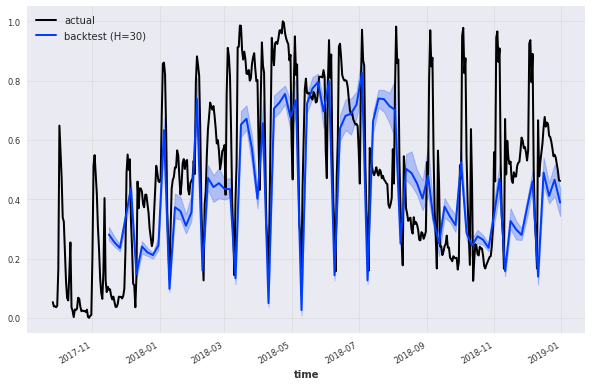

In [49]:
plt.figure(figsize=(10, 6))
series_en_transformed[1000:].plot(label="actual")
backtest_en.plot(label="backtest (H=30)", low_quantile=0.01, high_quantile=0.99)
plt.legend()